In [191]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from Scripts.dirty_accuracy import injection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN

## Helper functions

Classifier functions

Gaussian Classification implementation

In [192]:
def GaussianClassification(X_train, y_train, X_test, y_test):
    clf = GaussianProcessClassifier()
    clf.fit(X_train, y_train)
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    return [training_score, test_score]

K Neighbors Classification implementation

In [193]:
def KNClassification(X_train, y_train, X_test, y_test):
    K = []
    training = []
    test = []
    scores = {}

    for k in range(1, 20):
        clf = KNeighborsClassifier(n_neighbors = k)
        clf.fit(X_train, y_train)

        training_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)
        K.append(k)

        training.append(training_score)
        test.append(test_score)
        scores[k] = [training_score, test_score]
    return [training[test.index(np.max(test))],np.max(test)]

Print scores

In [194]:
def printScores(scores):
    for score in scores:
        print("Dataset dirty at: ", score['dirty'], "%")
        print(score['scores'][0],':', score['scores'][1])

Plot scores

In [195]:
def plotScores(scores, title):
    sns.set_palette("PuBuGn_d")
    for score in scores:
        labels = list(score['scores'].keys())
        labels.insert(0,0)
        scoresDF = pd.DataFrame.from_dict(score['scores'], orient='index', columns=['Train '+str(score['dirty']), 'Test '+str(score['dirty'])])
        plot = sns.lineplot(data=scoresDF)
        plot.set_xticks(range(len(score['scores'])+1))
        plot.set_xticklabels(labels)
        plot.set_ylim(0.2,1.1)
        plot.set(xlabel ="N Neighbors", ylabel = "Performance", title =title)
        plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Z-Score detection and correction

In [196]:
def ZS(data, threshold):
    mean = np.mean(data)
    sd = np.std(data)
    cleaned = []
    for i in data:
        z = (i - mean) / sd
        if abs(z) > threshold:
            cleaned.append(mean)
        else:
            cleaned.append(i)
    return cleaned

DBSCAN detection only

In [197]:
def DBSCANDetectionColumn(data, col):
    dbs = DBSCAN(eps = 0.1)
    dbs.fit_predict(data)
    data = data.drop("temp", axis = 1)
    correct = data[dbs.labels_ != -1]
    mu = correct[col].mean()
    print(mu)
    data.loc[dbs.labels_ == -1, col] = mu
    return data[col]

In [198]:
def DBSCANDetection(data):
    data["temp"] = 10
    columns = ["temp"]
    c = data.columns
    for col in c:
        if col != "temp":
            columns.append(col)
            data[col] = DBSCANDetectionColumn(data[columns], col)
    data = data.drop('temp', axis=1)
    return data

## Pipeline implementation

Read the dataset from CSV file
Drop the ID column

In [199]:
ecoli = pd.read_csv("datasets/ecoli.csv", sep=',')
ecoli = ecoli.drop('1', axis=1)

Perform the injections of outliers
and append the original clean dataset to the list

In [200]:
ecoli_list = injection(df_pandas=ecoli, seed=10, name='ecoli', name_class='class')
ecoli_list.append(ecoli)

saved ecoli-accuracy50%
saved ecoli-accuracy60%
saved ecoli-accuracy70%
saved ecoli-accuracy80%
saved ecoli-accuracy90%


Reverse the list on order to have
0 - Original Dataset
1 - 10% Dirty dataset
2 - 20% Dirty dataset
3 - 30% Dirty dataset
4 - 40% Dirty dataset
5 - 50% Dirty dataset

In [201]:
ecoli_list.reverse()

### Functions to be repeated for each dataframe

In [202]:
def computeScoresKN(dataframe_array):
    y = ecoli['class']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('class', axis=1, errors='ignore')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = KNClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [203]:
def computeScoresGC(dataframe_array):
    y = ecoli['class']
    scores = []
    i = 0
    for df in dataframe_array:
        X = df.drop('class', axis=1, errors='ignore')
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = GaussianClassification(X_train, y_train, X_test, y_test)
        scores.append({'dirty': i, 'scores': sc})
        i = i + 10
    return scores

In [204]:
def cleanDatasetsZS(datasets):
    cleaned_list = []
    i = 6
    for df in datasets:
        cleaned = df.copy()
        for col in cleaned.columns:
            if col == 'class':
                continue
            cleaned[col] = ZS(cleaned[col].values, i/10)
        cleaned_list.append(cleaned)
        i = i-1
    return cleaned_list

In [205]:
def cleanDatasetDBSCAN(datasets):
    cleaned_list = []
    for df in datasets:
        cleaned = df.copy()
        cleaned = cleaned.drop('class', axis=1)
        cleaned = DBSCANDetection(cleaned)
        cleaned_list.append(cleaned)
    return cleaned_list

### Performing K-Neighbors Machine Learning classification
Dataset preparation

In [206]:
knscores = computeScoresKN(ecoli_list)
printScores(knscores)

Dataset dirty at:  0 %
0.8638297872340426 : 0.8613861386138614
Dataset dirty at:  10 %
0.6893617021276596 : 0.6138613861386139
Dataset dirty at:  20 %
0.5446808510638298 : 0.5445544554455446
Dataset dirty at:  30 %
0.37872340425531914 : 0.49504950495049505
Dataset dirty at:  40 %
0.4553191489361702 : 0.45544554455445546
Dataset dirty at:  50 %
0.4595744680851064 : 0.4752475247524752


In [207]:
gcscore = computeScoresGC(ecoli_list)
printScores(gcscore)

Dataset dirty at:  0 %
0.7659574468085106 : 0.7227722772277227
Dataset dirty at:  10 %
0.825531914893617 : 0.49504950495049505
Dataset dirty at:  20 %
0.8765957446808511 : 0.4158415841584158
Dataset dirty at:  30 %
0.948936170212766 : 0.3465346534653465
Dataset dirty at:  40 %
0.9829787234042553 : 0.27722772277227725
Dataset dirty at:  50 %
0.9957446808510638 : 0.25742574257425743


Find column by column outliers using ZS and replace them with mean value

In [208]:
cleaned_zs_lists = cleanDatasetsZS(ecoli_list)
cleaned_dbs_list = cleanDatasetDBSCAN(ecoli_list)

0.5000595238095238
0.4970996978851964
0.4924924924924925
0.5
0.4978758169934641
0.4596634615384616
0.5004964539007092
0.4949539468768479
0.49865517241379315
0.4902923804853302
0.49995768101893207
0.4826070038910506
0.46231958762886605
0.4855555555555555
0.5772514322351315
0.4958015267175573
0.48976083787237146
0.49971646983892937
0.4901293103448276
0.4607526881720431
0.51375
0.5234961610561664
0.48932126696832573
0.48000000000000015
0.4997661033770021
0.5022680412371134
0.47818181818181815
0.48232558139534865
0.3482184416762348
0.5066666666666667
0.4799867323337761
0.5204974152641112
0.49617834394904464
0.45827272727272733
0.4288333333333333
0.3051715991791207
0.48202898550724643
0.5403869215144996
0.5
0.5022580645161291
0.4821176470588235
0.5197142857142857


Perform again the classification after outliers detection and print results

In [209]:
cleaned_knscores = computeScoresKN(cleaned_zs_lists)
cleaned_gcscores = computeScoresGC(cleaned_zs_lists)
cleaned_knscores_dbs = computeScoresKN(cleaned_dbs_list)
cleaned_gcscores_dbs = computeScoresGC(cleaned_dbs_list)

In [210]:
printScores(cleaned_knscores)

Dataset dirty at:  0 %
0.6212765957446809 : 0.5544554455445545
Dataset dirty at:  10 %
0.825531914893617 : 0.8514851485148515
Dataset dirty at:  20 %
0.7361702127659574 : 0.7821782178217822
Dataset dirty at:  30 %
0.7276595744680852 : 0.7029702970297029
Dataset dirty at:  40 %
0.7872340425531915 : 0.7128712871287128
Dataset dirty at:  50 %
0.6808510638297872 : 0.6732673267326733


In [211]:
printScores(cleaned_gcscores)

Dataset dirty at:  0 %
0.40425531914893614 : 0.4752475247524752
Dataset dirty at:  10 %
0.7106382978723405 : 0.6831683168316832
Dataset dirty at:  20 %
0.6553191489361702 : 0.6831683168316832
Dataset dirty at:  30 %
0.6170212765957447 : 0.6534653465346535
Dataset dirty at:  40 %
0.6468085106382979 : 0.594059405940594
Dataset dirty at:  50 %
0.5872340425531914 : 0.594059405940594


In [212]:
printScores(cleaned_knscores_dbs)

Dataset dirty at:  0 %
0.774468085106383 : 0.7326732673267327
Dataset dirty at:  10 %
0.825531914893617 : 0.7326732673267327
Dataset dirty at:  20 %
0.7489361702127659 : 0.6732673267326733
Dataset dirty at:  30 %
0.7319148936170212 : 0.6633663366336634
Dataset dirty at:  40 %
0.6553191489361702 : 0.594059405940594
Dataset dirty at:  50 %
0.6042553191489362 : 0.6435643564356436


In [213]:
printScores(cleaned_gcscores_dbs)

Dataset dirty at:  0 %
0.6723404255319149 : 0.6435643564356436
Dataset dirty at:  10 %
0.6297872340425532 : 0.6039603960396039
Dataset dirty at:  20 %
0.6212765957446809 : 0.6039603960396039
Dataset dirty at:  30 %
0.5914893617021276 : 0.594059405940594
Dataset dirty at:  40 %
0.5319148936170213 : 0.49504950495049505
Dataset dirty at:  50 %
0.49361702127659574 : 0.5148514851485149


### Plot data preparation

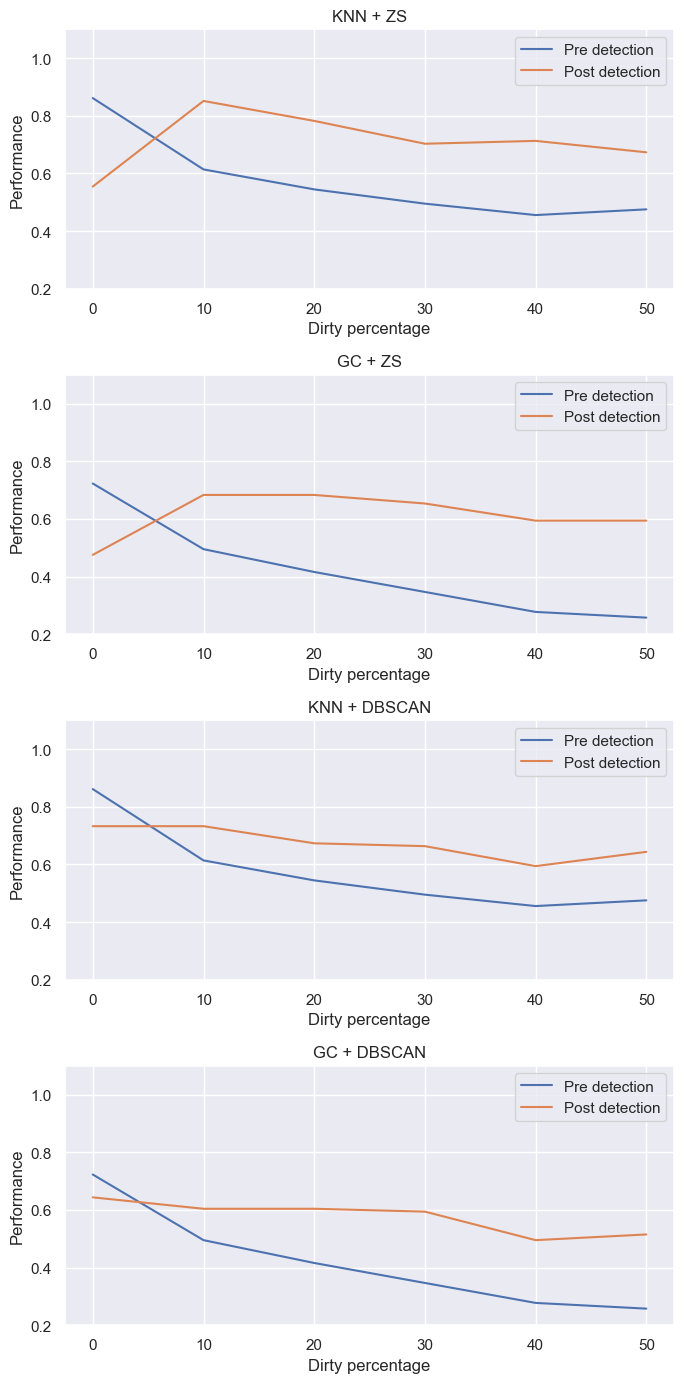

In [214]:
def toArray(score):
    t = []
    for s in score:
        t.append(s['scores'][1])
    return t
plotData = {
    'dirty': [0, 10, 20, 30, 40, 50],
    'knc_pre': toArray(knscores),
    'gc_pre': toArray(gcscore),
    'knc_zs_post': toArray(cleaned_knscores),
    'gc_zs_post': toArray(cleaned_gcscores),
    'knc_dbs_post': toArray(cleaned_knscores_dbs),
    'gc_dbs_post': toArray(cleaned_gcscores_dbs)
}
plotDF = pd.DataFrame(plotData)
sns.set()
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(7,14))

sns.lineplot(ax=axes[0], x='dirty', y='knc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='knc_zs_post', data=plotDF)
axes[0].legend(['Pre detection', 'Post detection'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('KNN + ZS')

sns.lineplot(ax=axes[1], x='dirty', y='gc_pre', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='gc_zs_post', data=plotDF)
axes[1].legend(['Pre detection', 'Post detection'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('GC + ZS')

sns.lineplot(ax=axes[2], x='dirty', y='knc_pre', data=plotDF)
sns.lineplot(ax=axes[2], x='dirty', y='knc_dbs_post', data=plotDF)
axes[2].legend(['Pre detection', 'Post detection'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('KNN + DBSCAN')

sns.lineplot(ax=axes[3], x='dirty', y='gc_pre', data=plotDF)
sns.lineplot(ax=axes[3], x='dirty', y='gc_dbs_post', data=plotDF)
axes[3].legend(['Pre detection', 'Post detection'])
axes[3].set(xlabel='Dirty percentage', ylabel='Performance')
axes[3].set_ylim(0.2,1.1)
axes[3].set_title('GC + DBSCAN')
fig.tight_layout()

Text(0.5, 1.0, 'Post detection DBSCAN performances')

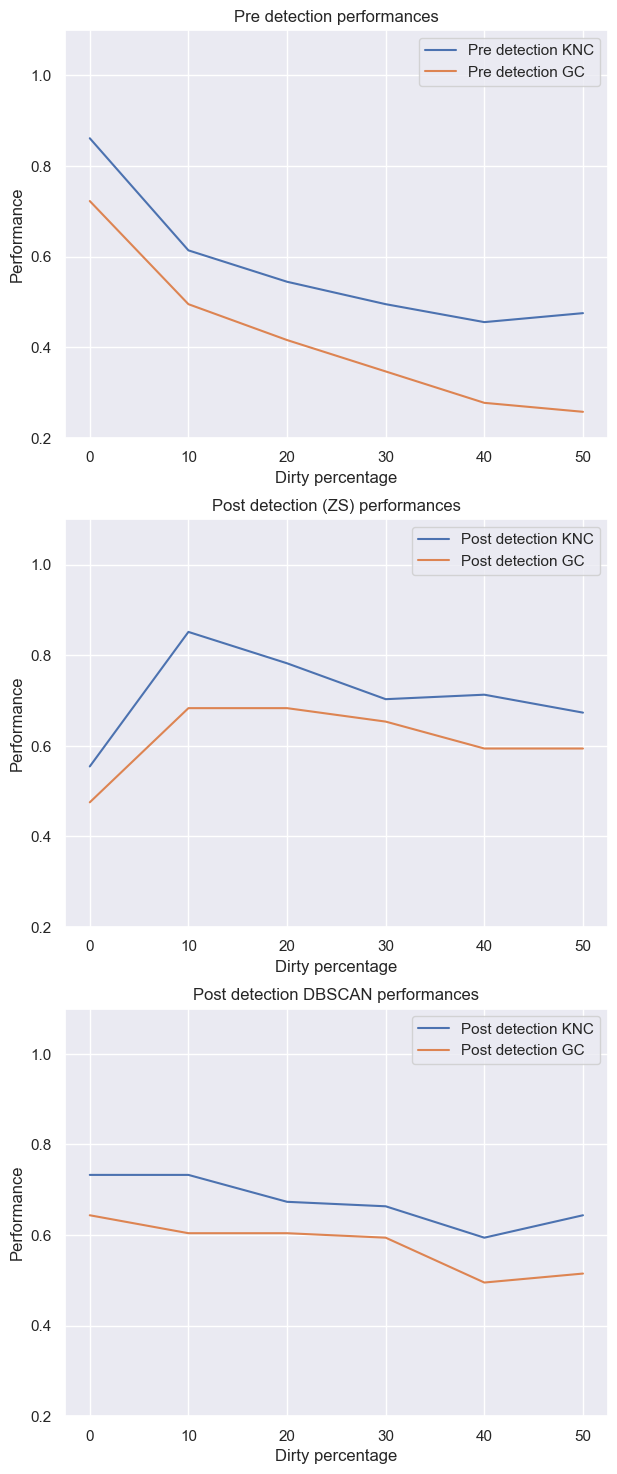

In [215]:
sns.set()
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(7,18))

sns.lineplot(ax=axes[0], x='dirty', y='knc_pre', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='gc_pre', data=plotDF)
axes[0].legend(['Pre detection KNC', 'Pre detection GC'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('Pre detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='knc_zs_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='gc_zs_post', data=plotDF)
axes[1].legend(['Post detection KNC', 'Post detection GC'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('Post detection (ZS) performances')

sns.lineplot(ax=axes[2], x='dirty', y='knc_dbs_post', data=plotDF)
sns.lineplot(ax=axes[2], x='dirty', y='gc_dbs_post', data=plotDF)
axes[2].legend(['Post detection KNC', 'Post detection GC'])
axes[2].set(xlabel='Dirty percentage', ylabel='Performance')
axes[2].set_ylim(0.2,1.1)
axes[2].set_title('Post detection DBSCAN performances')

Text(0.5, 1.0, 'GC Post-detection performances')

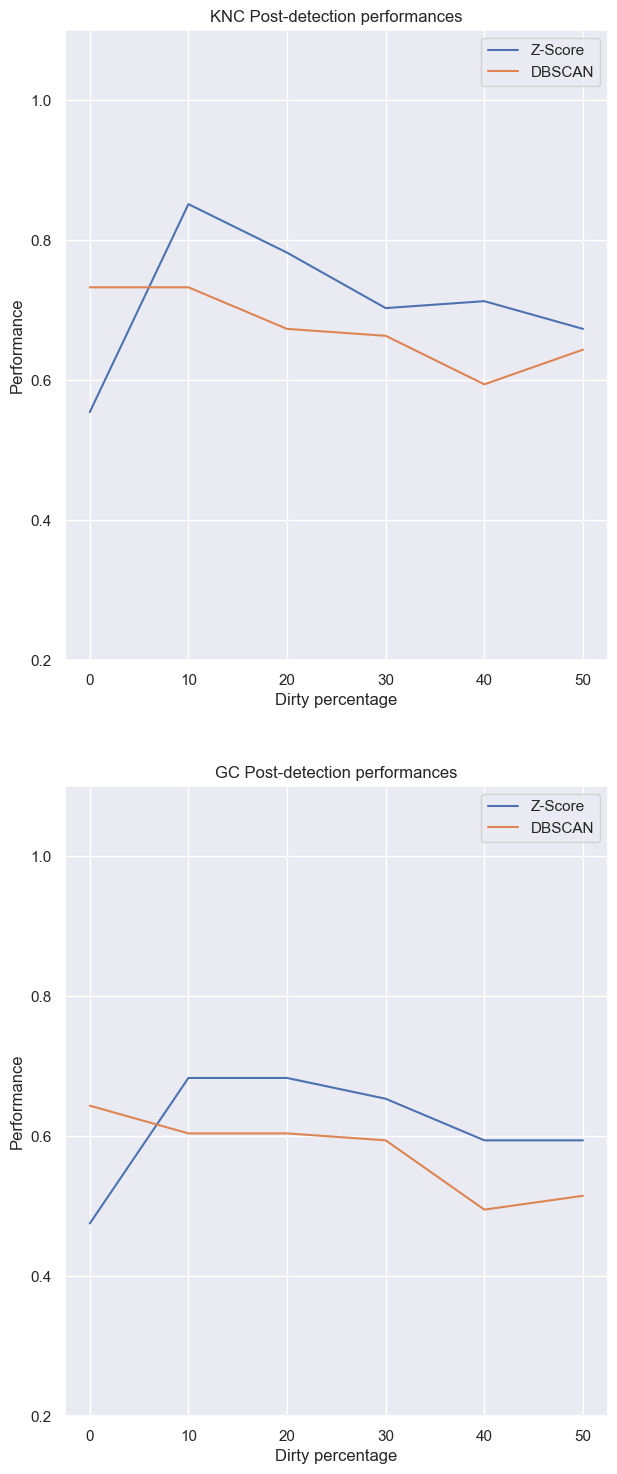

In [216]:
sns.set()
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(7,18))

sns.lineplot(ax=axes[0], x='dirty', y='knc_zs_post', data=plotDF)
sns.lineplot(ax=axes[0], x='dirty', y='knc_dbs_post', data=plotDF)
axes[0].legend(['Z-Score', 'DBSCAN'])
axes[0].set(xlabel='Dirty percentage', ylabel='Performance')
axes[0].set_ylim(0.2,1.1)
axes[0].set_title('KNC Post-detection performances')

sns.lineplot(ax=axes[1], x='dirty', y='gc_zs_post', data=plotDF)
sns.lineplot(ax=axes[1], x='dirty', y='gc_dbs_post', data=plotDF)
axes[1].legend(['Z-Score', 'DBSCAN'])
axes[1].set(xlabel='Dirty percentage', ylabel='Performance')
axes[1].set_ylim(0.2,1.1)
axes[1].set_title('GC Post-detection performances')